# Ensemble using gridsearch function

In [6]:
from numpy import loadtxt
# load array

cnn_prob = loadtxt('C:/Users/nishu/Downloads/y_pred_3.csv', delimiter=',')
svm_prob = loadtxt('C:/Users/nishu/Downloads/y_pred_2.csv', delimiter=',')
# print the array


In [7]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def ensemble_predictions(yhats,weights):

    # weighted sum across ensemble members
    #summed = tf.tensordot(yhats, weights, axes=((0),(0)))
    w, h = 1728, 90
    summed = [[0 for x in range(w)] for y in range(h)] 
    #print(summed)
    for i in range(1728):
        for x in range(90):
            summed[x][i]=0
            for y in range(2):
                summed[x][i]=summed[x][i]+(yhats[y][i][x])*weights[y]
    # argmax across classes
    result = np.argmax(summed, axis=0)
    return result
 




def evaluate_ensemble(yhats,testy,weights):
    # make prediction
    yhat = ensemble_predictions(yhats,weights)
    # calculate accuracy
    return accuracy_score(testy, yhat)



def loss_function(yhats,testy,weights):
    # normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return 1.0 - evaluate_ensemble(yhats,testy,weights)

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = tf.norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result


testdata=pd.read_csv('C:/Users/nishu/Downloads/y_test.csv')

yhats=[cnn_prob,svm_prob]
yhats = np.array(yhats,dtype='object')
#yhats = tf.convert_to_tensor(yhats,dtype=np.ndarray)
#print(yhats[1][0][0])

testy=[i for i in testdata['label']]

cnn_pred=pd.read_csv('C:/Users/nishu/Downloads/y_pred_cnn.csv')
svm_pred=pd.read_csv('C:/Users/nishu/Downloads/y_pred_svm.csv')

y_cnn=[i for i in cnn_pred['y_pred_cnn']]
y_svm=[i for i in svm_pred['y_pred_svm']]
y = [ y_cnn, y_svm]

n_members = 2
# evaluate each single model on the test set
for i in range(n_members):
    test_acc = accuracy_score(testy, y[i])
    print(test_acc)
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
weights=np.array(weights)

#weights = tf.convert_to_tensor(weights,dtype=np.float32)
score=evaluate_ensemble(yhats, testy, weights)
print('Weights Score: %.3f' % score)


0.5486111111111112
0.7679398148148148
Weights Score: 0.675


In [8]:
def grid_search(yhats,testy,weights):
    # define weights to consider
    w = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    best_score, best_weights = 0.0, None
    # iterate all possible combinations (cartesian product)
    for weights in product(w, repeat=2):
        # skip if all weights are equal
        if len(set(weights)) == 1:
            continue
        # hack, normalize weight vector
        weights = normalize(weights)
        # evaluate weights
        score = evaluate_ensemble(yhats, testy,weights)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.3f' % (best_weights, best_score))
    return list(best_weights)

In [9]:
from itertools import product
 
# grid search weights
weights = grid_search(yhats, testy, weights)
score = evaluate_ensemble(yhats, testy, weights)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

>tf.Tensor([0.3333333 0.6666666], shape=(2,), dtype=float32) 0.740
>tf.Tensor([0.25 0.75], shape=(2,), dtype=float32) 0.764
>tf.Tensor([0.2 0.8], shape=(2,), dtype=float32) 0.769
>tf.Tensor([0.16666666 0.8333333 ], shape=(2,), dtype=float32) 0.778
>tf.Tensor([0.14285713 0.8571428 ], shape=(2,), dtype=float32) 0.785
>tf.Tensor([0.1 0.9], shape=(2,), dtype=float32) 0.785
Grid Search Weights: [<tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9>], Score: 0.785


In [10]:
pred=ensemble_predictions(yhats,weights) 

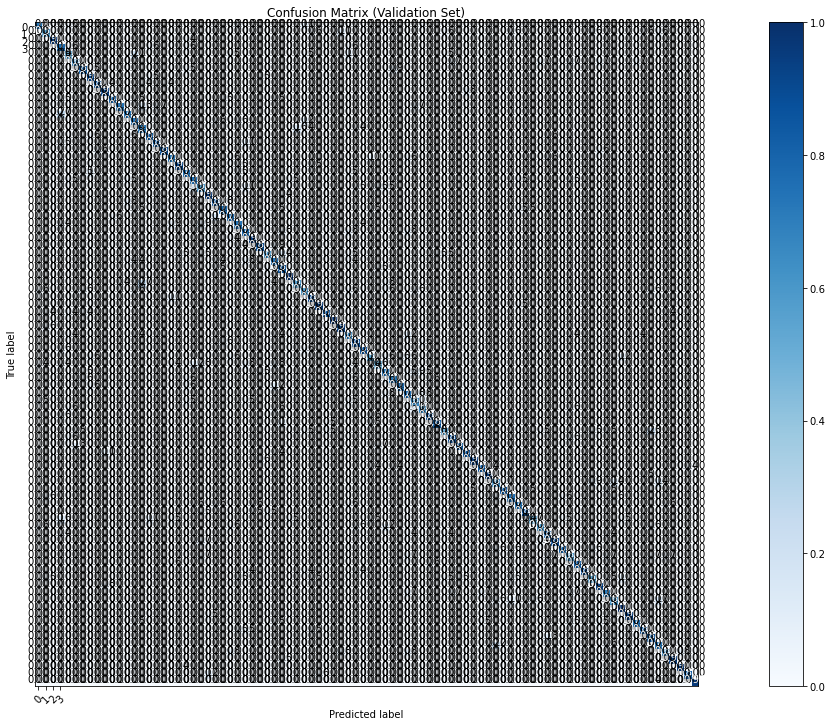

In [11]:
from sklearn.metrics import confusion_matrix
from itertools import product
import matplotlib.pyplot as plt
cnf_matrix = confusion_matrix(testy, pred)
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix,labels=None)

# precision = true_pos / (true_pos + false_p

In [12]:
y_test=list(testdata['label'])

In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        18
           1       0.71      0.56      0.63        18
           2       1.00      0.96      0.98        24
           3       0.48      0.78      0.60        18
           4       0.56      0.47      0.51        19
           5       0.77      0.67      0.71        15
           6       0.78      0.82      0.80        22
           7       0.75      0.90      0.82        20
           8       0.95      0.88      0.91        24
           9       0.69      0.92      0.79        12
          10       0.94      0.80      0.86        20
          11       0.92      0.73      0.81        15
          12       0.73      0.73      0.73        15
          13       0.52      0.75      0.62        16
          14       0.64      0.72      0.68        25
          15       0.79      0.83      0.81        18
          16       0.94      0.84      0.89        19
          17       0.94    